##  Random forest with the injected data set 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

### Read in the data from Kelsey's file

In [2]:
ddir = "data/"
tcefile = "TESS_ML_20240412.txt"
columns = ["pass","win","type","injnum","period","tzero","power","dur","depth","snr","deptest1","deptest2",
           "stmass","stradius","chisq",
           "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3","mindBIC",
           "nloops","npoints",
           "nintransit","26","27","28","29","30","31",
           "Tmag","Teff","logg","injrec","trprob"]
tces = pd.read_csv(ddir+tcefile, names=columns)

In [3]:
# This is how well Jason's RF runs written as a confusion matrix
#Originally Jason/Kelsey Confusion Matrix
injected = tces['injrec'] == 1

for prob in np.arange(0.1,1,.2):
    jasonpassed = tces['trprob'] > prob  #This is arbitrary

    num00 = len(tces[~injected & ~jasonpassed])
    num01 = len(tces[~injected & jasonpassed])
    num10 = len(tces[injected & ~jasonpassed])
    num11 = len(tces[injected & jasonpassed])

    print("   ==>  For the Probability %f:" % prob)
    #print([num00,num01],"\n",[num10,num11])

    print(100*np.array([num00,num01])/(num00+num01),"\n",
          100*np.array([num10,num11])/(num10+num11))

   ==>  For the Probability 0.100000:
[98.07989365  1.92010635] 
 [  0. 100.]
   ==>  For the Probability 0.300000:
[99.52863308  0.47136692] 
 [ 3.127238 96.872762]
   ==>  For the Probability 0.500000:
[99.8745518  0.1254482] 
 [ 7.25113392 92.74886608]
   ==>  For the Probability 0.700000:
[9.99920425e+01 7.95753485e-03] 
 [12.84912867 87.15087133]
   ==>  For the Probability 0.900000:
[100.   0.] 
 [24.28383862 75.71616138]


In [7]:
metrics=[ #"period",
         #"power",
         "dur","depth",
         "snr",
         "deptest1","deptest2",
         "chisq",
         "bicft","bicplus","bicminus","snrshape","noise",
         "depth_shape2","depth_shape3",
         "mindBIC",
         "nloops",
         "npoints",
         "nintransit",
         #"26","27","28","29","30","31",
         #"Tmag", "logg", "Teff"
         ]

X = np.array(tces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
X_train, X_test, y_train, y_test = train_test_split(X, tces['injrec'], test_size=0.2)
X_train[0]

array([ 7.612070e-01, -3.460700e-02, -1.342858e+01, -2.737238e+00,
       -1.158041e+00,  1.180000e+00,  1.371400e+02,  3.070000e+01,
        6.252000e+01, -1.260000e+01,  2.062900e-02,  4.600000e+00,
        4.000000e+00,  3.070000e+01,  1.520000e+02,  9.833000e+03,
        5.800000e+01])

In [8]:
rf = RandomForestClassifier(n_estimators=40,max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

Cross Validation Score mean: 0.989697


Accuracy: 0.989192239246495


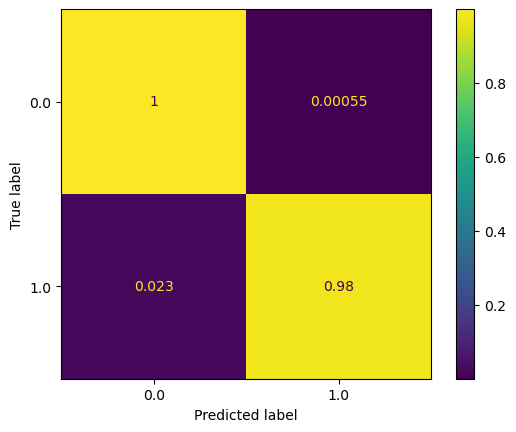

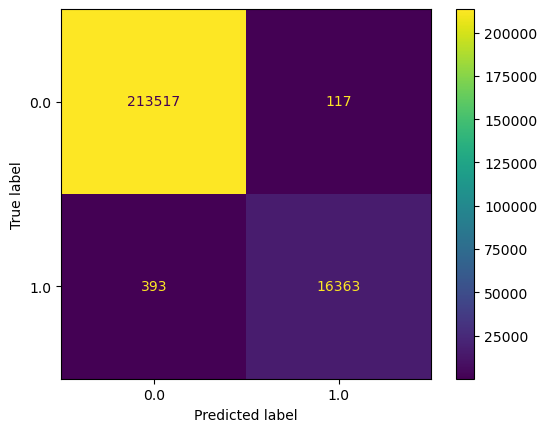

In [9]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

## Compare and Improve

This appears to be only an 82% completeness and accuracy of 0.9801
Ways I tried to improve the training to get what I have above wihtout changing the metrics is the following:

- Max depth went from 4 --> None.  This greatly improved things to a 0.987 mean accuracy and only losing 4% of the  injected signals with true with less than 0.04% of false positives miscalssified.
- I tried increasing the number is split samples to 4, but seemed to make things a bit worse.
- I looked at n_estimators from 10 --> 20, this gave me significant improvement.No only missing 2.9% of the true positives and now 0.07% of the false positives misclassified. (39 s runtime)
- I doubled the number of classifiers again to 40. This got me to 2.4% and 0.073%.  so let's stop there with that one.



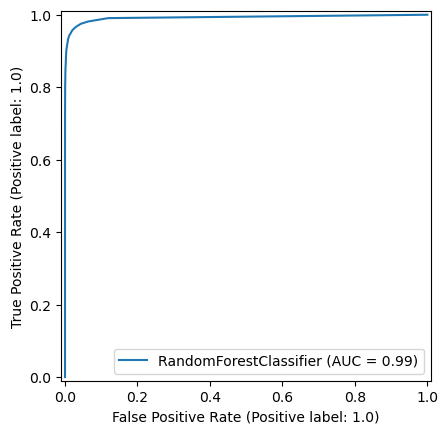

In [10]:
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
from sklearn.metrics import roc_auc_score


In [11]:
#Get probabilities
from sklearn.metrics import roc_auc_score
y_prob = rf.predict_proba(X)
y_test_prob = rf.predict_proba(X_test)
roc_auc_score(y_test, y_test_prob[:,1])

0.9923655467719978

In [12]:
#Record the results in the TCEs for the entire data set.
y_all = rf.predict(X)
y_prob = rf.predict_proba(X)

tces['newRF'] = y_all
tces['newRFprob'] = y_prob[:,1]  #Probability it is class "transit"

Text(0, 0.5, 'Susan Score')

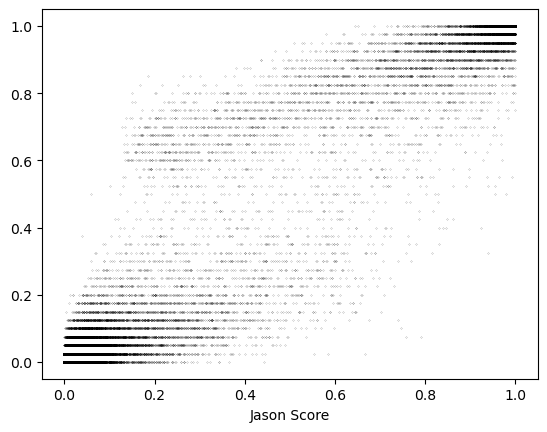

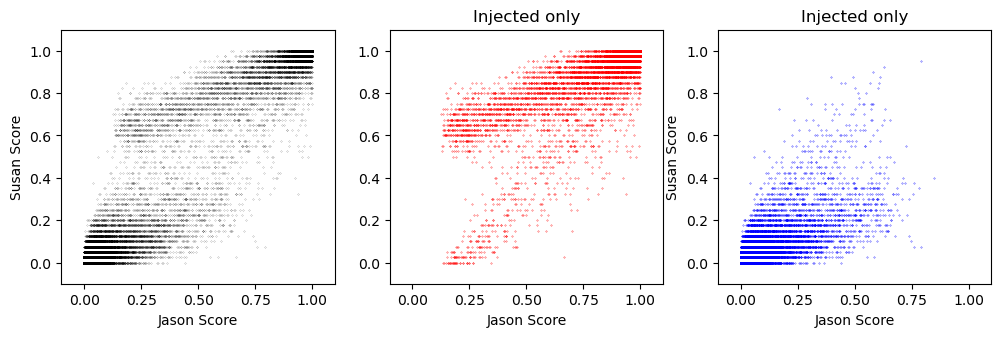

In [13]:
#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
jasonpassed = tces['trprob'] > 0.5
rfpassed = tces['newRFprob'] >0.5

plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
falsepos = tces['injrec'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.subplot(132)
plt.plot(tces[injected]['trprob'],tces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')

plt.subplot(133)
plt.plot(tces[falsepos]['trprob'],tces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')
plt.tight_layout
plt.ylabel('Susan Score')

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

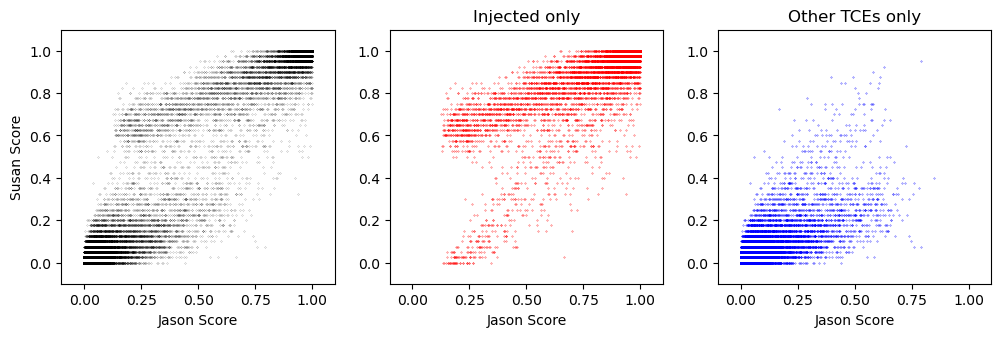

In [14]:
#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
falsepos = tces['injrec'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.subplot(132)
plt.plot(tces[injected]['trprob'],tces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')

plt.subplot(133)
plt.plot(tces[falsepos]['trprob'],tces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Other TCEs only')
plt.tight_layout

## Compare the probability score with the binary score.
Does it just apply a threshold to determine the binary score.  Plotting 0,1 vs probability should show that.
Apparently a threshold of 0.5 in the probability score is the same as the binary result.

## Let's learn somethign about the ones I'm getting wrong.

In [16]:
tces.columns

Index(['pass', 'win', 'type', 'injnum', 'period', 'tzero', 'power', 'dur',
       'depth', 'snr', 'deptest1', 'deptest2', 'stmass', 'stradius', 'chisq',
       'bicft', 'bicplus', 'bicminus', 'snrshape', 'noise', 'depth_shape2',
       'depth_shape3', 'mindBIC', 'nloops', 'npoints', 'nintransit', '26',
       '27', '28', '29', '30', '31', 'Tmag', 'Teff', 'logg', 'injrec',
       'trprob', 'newRF', 'newRFprob'],
      dtype='object')

(0.0, 20.0)

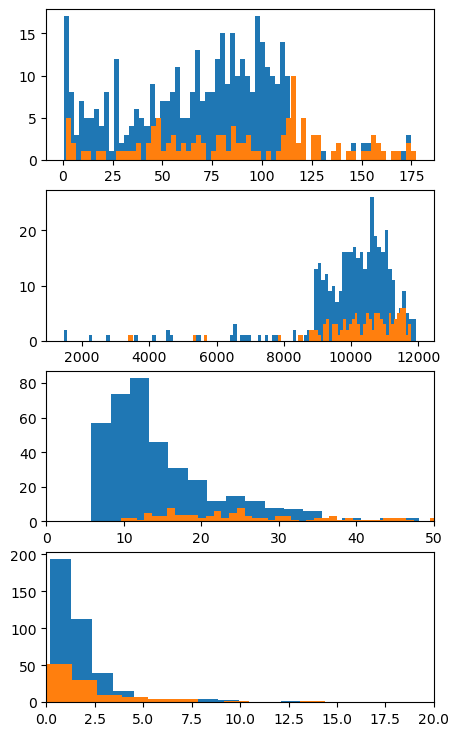

In [37]:
#Injected but didn't pass them.
want = injected & ~rfpassed
extces = tces[want]
fptces = tces[~injected & rfpassed]

plt.figure(figsize=(5,9))
plt.subplot(4,1,1)
_,_,_ = plt.hist(extces['period'], 70)
_,_,_ = plt.hist(fptces['period'], 70)
plt.subplot(4,1,2)
_,_,_ = plt.hist(extces['npoints'], 100)
_,_,_ = plt.hist(fptces['npoints'], 100)
plt.subplot(4,1,3)
_,_,_ = plt.hist(extces['snr'], 150)
_,_,_ = plt.hist(fptces['snr'], 150)
plt.xlim(0,50)
plt.subplot(4,1,4)
_,_,_ = plt.hist(extces['chisq'], 100)
_,_,_ = plt.hist(fptces['chisq'], 100)
plt.xlim(0,20)

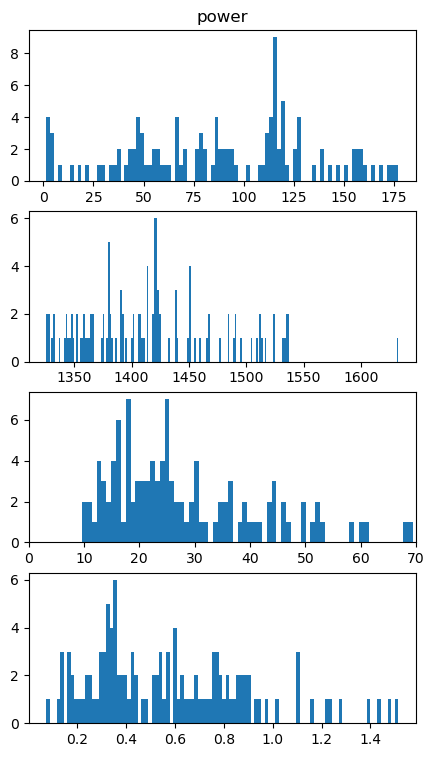

In [25]:
#Not injected, but passed
want = ~injected & rfpassed
extces = tces[want]

plt.figure(figsize=(5,9))
plt.subplot(4,1,1)
_,_,_ = plt.hist(extces['period'], 90)
plt.title('power')
plt.subplot(4,1,2)
_,_,_ = plt.hist(extces['tzero'], 200)
plt.subplot(4,1,3)
_,_,_ = plt.hist(extces['snr'], 170)
plt.xlim(0,70)
plt.subplot(4,1,4)
_,_,_ = plt.hist(extces['dur'], 100)

## Try splitting on Period

Period seems to have trends of not passing many of the injected after abotu 50 days.
But the number of false positives is still flat.

In [52]:
metrics=[ #"period",
         #"power",
         "dur","depth",
         "snr",
         "deptest1","deptest2",
         "chisq",
         "bicft","bicplus","bicminus","snrshape","noise",
         "depth_shape2","depth_shape3",
         "mindBIC",
         "nloops",
         "npoints",
         "nintransit",
         #"26","27","28","29","30","31",
         #"Tmag", "logg", "Teff"
         ]

## Do just low period tces and separately the long period ones.

origtces = tces
g1tces = origtces[origtces['period']<13]
g2tces = origtces[origtces['period']>13]

Xg1 = np.array(g1tces[metrics])
Xg1[~np.isfinite(Xg1)] = -9999

Xg2 = np.array(g2tces[metrics])
Xg2[~np.isfinite(Xg2)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
Xg1_train, Xg1_test, yg1_train, yg1_test = train_test_split(Xg1, g1tces['injrec'], test_size=0.2)

#Here we define the test and training sets using a routine written by Scikitlearn
Xg2_train, Xg2_test, yg2_train, yg2_test = train_test_split(Xg2, g2tces['injrec'], test_size=0.2)

In [53]:
#Group one, group 1, <50 day ones
rf = RandomForestClassifier(n_estimators=40,max_depth=None, min_samples_split=2, random_state=0)
rf.fit(Xg1_train, yg1_train)
scores= cross_val_score(rf, Xg1_train, yg1_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())


Cross Validation Score mean: 0.996884


Accuracy: 0.9968994096953073


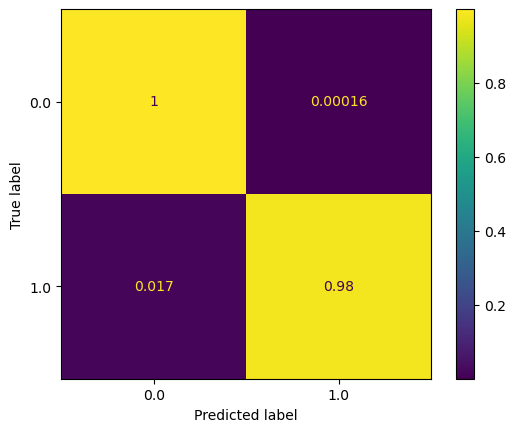

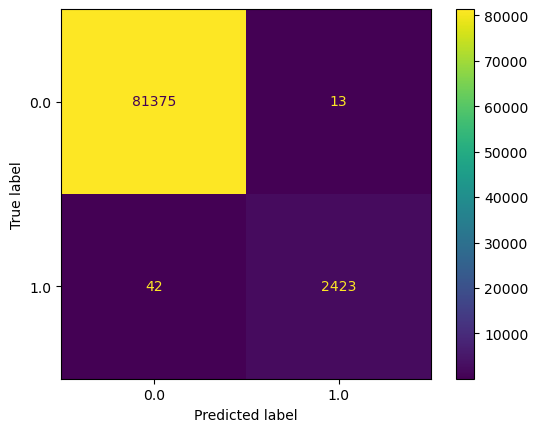

In [54]:
yg1_pred = rf.predict(Xg1_test)
accuracy = accuracy_score(yg1_test, yg1_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=yg1_pred, y_true = yg1_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, Xg1, g1tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, Xg1, g1tces['injrec'])

In [55]:
#Group one, group 1, >50 day ones
rf = RandomForestClassifier(n_estimators=40,max_depth=None, min_samples_split=2, random_state=0)
rf.fit(Xg2_train, yg2_train)
scores= cross_val_score(rf, Xg2_train, yg2_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())


Cross Validation Score mean: 0.985626


Accuracy: 0.9846799508666576


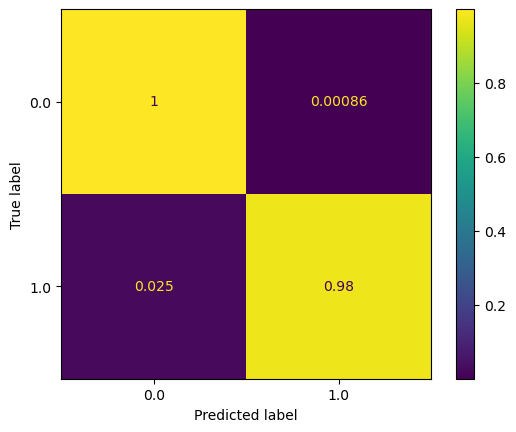

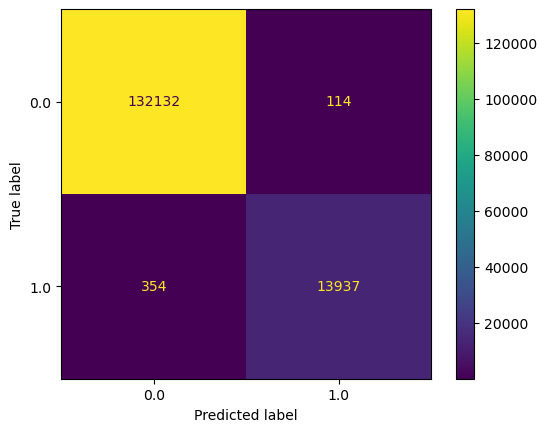

In [56]:
yg2_pred = rf.predict(Xg2_test)
accuracy = accuracy_score(yg2_test, yg2_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=yg2_pred, y_true = yg2_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, Xg2, g2tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, Xg2, g2tces['injrec'])

## Results

Train different above and below some threshold.  When I think about it shouldn't make much of. adifference because this is how a random forest works, but randomly and robustly, as long as we have enough levels.

The results are about the same when split at 50 days, still 116 vs 117 of the true negatives are classified as possitive and 373 vs 393 of the True positives are classified as negative.  So slightly better, but not by much.

When split at 13 days.. I similarly do no better, and maybe actually worse.

## Try messing with a differt type of classifier.

In [75]:
metrics=[ #"period",
         #"power",
         #"dur","depth",
         "snr",
         "deptest1","deptest2",
         #"chisq",
         "bicft","bicplus","bicminus",
         #"snrshape","noise",
         #"depth_shape2","depth_shape3",
         "mindBIC",
         #"nloops",
         #"npoints",
         #"nintransit",
         #"26","27","28","29","30","31",
         #"Tmag", "logg", "Teff"
         ]

X = np.array(tces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
X_train, X_test, y_train, y_test = train_test_split(X, tces['injrec'], test_size=0.2)
X_train[0]

array([-5.967352, -2.22589 , -1.682317, 44.43    , 13.12    , 13.17    ,
       13.12    ])

In [81]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

est = make_pipeline(StandardScaler(), 
                    SGDClassifier(loss="modified_huber", penalty="l2", max_iter=305)
                   )
est.fit(X_train, y_train)
est.predict(X_test, y_test)

scores= cross_val_score(est, X_train, y_train, cv=7)
print("Cross Validation Score mean: %f" % scores.mean())


SyntaxError: invalid syntax (768461333.py, line 8)

Accuracy: 0.8786622683276184


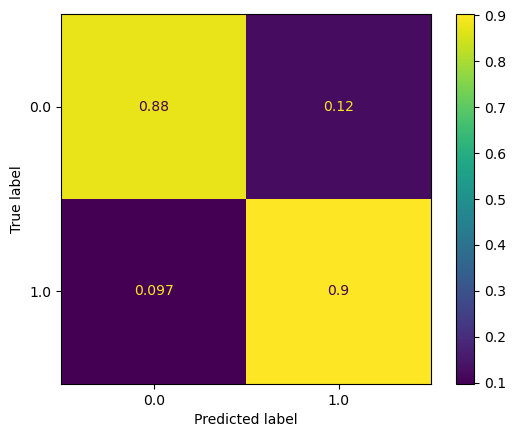

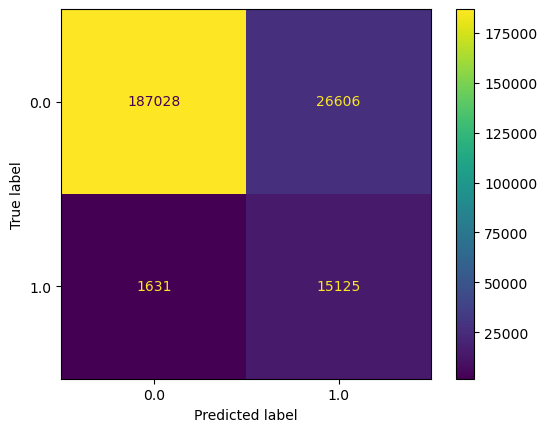

In [74]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(clf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(clf, X, tces['injrec'])

In [ ]:
#Minibatchkmeans
